In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [16]:
# how to create the original substitution cipher.
# We'll also need the string library, which provides us with a convenient way to load all the valid ASCII
# random library to shuffle the ASCII characters and create our substitution cipher
# regex library to do some string operations later on in the scripts

import numpy as np
import matplotlib.pyplot as plt
import string
import pandas as pd
import random 
import os
import textwrap
import requests
import re

In [3]:
# CREATE substitution cipher

# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# shuffle the letters 2 
random.shuffle(letters2)

# populate map
for k,v in zip(letters1, letters2):
  true_mapping[k] = v

In [4]:
# First, we need a marker matrix to store all the bigram probabilities
# since there are 26 starting letters and 26 ending letters, we must have a 26 by 26 matrix. We also need a vector to store all the unit gram probabilities, but to be more specific
# This will represent the initial state distribution. we don't care about unit grams that appear later in a word, or we just care about the first letter

# language model
# initialize markov matrix
M = np.ones((26,26))

# initial state distribution
pi = np.zeros(26)

# function to update markov matrix
# ch1 - starting char, ch2 - ending char. Important thing to remember is that in order to index a matrix, we must use integers since the number of rows and columns of The Matrix 
# are both 26, Then the indices will be from zero to 25 inclusive
def update_transition(ch1, ch2):
  # ord('a') = 97, ord('b') = 98, ...
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1

# function to update initial state dsitribtuion
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

# get the uni-gram probability by taking the first letter in the word, word at index zero. We convert that into an index and then we find its probability by indexing PI
# we take the log since we would prefer to work in log space and assign this to a variable called logp. we convert the current character C-H into an integer j using 
# the same method as before. variable I still represents the previous letter, so now we can index em at position I.J to get the next bigram probability.
# We take the log of this and then add it to log P. the current letter becomes the previous letter on the next iteration of this loop

# get the log probability of given word or token
def get_word_prob(word):
  # print("word :", word)
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j]) # update prob
    i = j

  return logp

# get the probability of a sequence of words
# it can be a string containing multiple words i.e. a sentence, or it can be a list containing multiple words, each stored as a string.
# if the input argument is a string, then we'll call words that split in order to convert it into a list of strings. we can be sure that the words variable is a list containing strings
# each of which are individual words
def get_sequence_prob(words):
  # if input is a string, split to tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)

  return logp


In [5]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)

# download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

In [30]:
# remove any non alphabet characters
regex = re.compile('[^a-zA-Z]')

# load in words 
# strip out any whitespace by calling r.strip. some lines in the file are just blank since we called the strip function previously if this line is blank, 
# it'll now be an empty string, which would have failed this condition

# load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [7]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [31]:
# function to encode a message it takes as input, a raw message such as the above and returns cipher text representing that message using the substitution cipher that we defined at start
# our mapping only contains lowercase letters regex familiar to replace all non alpha characters with a space This is because we do not have any mappings for non alpha characters.
# enter a loop to build up the coded message initializing the coded message as an empty list will be converting and storing each character one at a time

# a function to encode a message
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)


encoded_message = encode_message(original_message)

# function to decode the message this takes in two arguments a cipher text message and a word map. This function largely works the same as the encode function.
# It just maps each character in the input to a different character, according to the word map. It's just that this word map is an argument to the function, 
# whereas for encoding the word map was the true mapping we defined earlier.

# a function to decode a message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

In [32]:
encoded_message = encode_message(original_message)
encoded_message

'h nyje csdemjq qsve nyj pnfjjn req gsdeq  rp h jowjanjq  nyrn nyjfj vrp r zjvp he r crej vyhay fdep qsve lb sej vrcc sg nyj mrfqje  h cjen nyj spncjfp r yreq he fdllhem qsve nyjhf ysfpjp  req fjajhkjq he joayremj nvswjeaj  r mcrpp sg yrcg req yrcg  nvs ghccp sg pyrm nslraas  req rp zday hegsfzrnhse rp h asdcq qjphfj rlsdn zhpp rqcjf  ns prb esnyhem sg yrcg r qsije snyjf wjswcj he nyj ejhmylsdfyssq he vysz h vrp esn he nyj cjrpn henjfjpnjq  ldn vyspj lhsmfrwyhjp h vrp aszwjccjq ns chpnje ns  '

In [33]:
# To initialize the algorithm, we must create a DNA pool containing 20 DNA strings.we initialize a variable called DNA pool and make that an empty list.
# Then we do a loop that iterates at 20 times. Inside the loop we create a DNA string, which is just a list containing the lowercase alphabet
# By the end of this loop will have 20 random DNA strings

# initialization point
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)  

In [34]:
# This takes in two arguments an existing DNA pool and the number of children that each individual will create. Inside the function will initialize the offspring list to be an empty list
# Then we'll do a nested loop on the outer loop we lived through each parent in the DNA pool, on the inner loop We'll iterate through the number of children that we need to create in order
#  to create the child all we want to do is a random swap. So first, we need to make a copy of the parent so that we don't overwrite it. Next, we choose to random iness J and K, which will 
# be the two positions that we want to swap. These are just two random numbers between zero and 25 inclusive. Then we do the switch.
# When we've completed the loop, we combine the offspring list with the parent list and then return that as the final population.

def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)

  return offspring + dna_pool

In [35]:
#  number of iterations of the loop to do so That's currently 1000. That's the number of generations of offspring that we want to evolve.
# we initialize an array called scores, which will store the average score at each iteration of the loop. we want to keep track of some things the best DNA, 
# which corresponds to the best map, which corresponds to the best score. Best score is initialized to minus infinity, which is the minimum possible score.
# we enter the main loop, which runs num_iters times inside the loop we first check if it's the first iteration or not. If it is, then I will be zero and 
# there's no need to create new offspring yet because we haven't yet evaluated them. If it's not the first iteration, then we need to create new offspring by 
# calling the function we defined.

num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)


iter: 0 score: -2828.0296374148206 best so far: -2401.0500537873854
iter: 200 score: -1097.3923043305408 best so far: -944.7603610986953
iter: 400 score: -1095.267506948363 best so far: -938.6428307084827
iter: 600 score: -1162.9775965306371 best so far: -938.6428307084827
iter: 800 score: -1035.6668906032778 best so far: -938.6428307084827


In [36]:
# print out the log likelihood of this decoded message, along with the log likelihood of the true message.
# Remember that the best map is a reverse mapping because we were using it for decoding rather than encoding.So pred is the value in the reverse mapping, 
# whereas true was the key in the true mapping.

# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))
  

LL of decoded message: -938.6428307084827
LL of true message: -932.9508705551947
true: b, pred: m
true: j, pred: q
true: k, pred: z
true: m, pred: b
true: p, pred: y
true: q, pred: j
true: y, pred: p
true: z, pred: k


In [37]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i exyected  that there
was a bews in a lane which runs down mp one wall of the garden  i lent
the ostlers a hand in rumming down their horses  and received in
exchange twoyence  a glass of half and half  two fills of shag tomacco
and as buch inforbation as i could desire amout biss adler  to sap
nothing of half a doken other yeoyle in the neighmourhood in whob i
was not in the least interested  mut whose miograyhies i was cobyelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

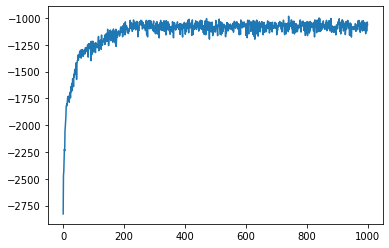

In [38]:
plt.plot(scores)
plt.show()

In [39]:
len(dna_pool)

5

In [41]:
dna_pool

[['c',
  'p',
  'l',
  'u',
  'n',
  'r',
  'f',
  'i',
  'k',
  'e',
  'v',
  'm',
  'g',
  't',
  'x',
  's',
  'd',
  'a',
  'o',
  'q',
  'z',
  'w',
  'y',
  'j',
  'h',
  'b'],
 ['c',
  'p',
  'l',
  'u',
  'n',
  'r',
  'f',
  'i',
  'k',
  'e',
  'v',
  'm',
  'g',
  't',
  'x',
  's',
  'd',
  'a',
  'o',
  'j',
  'z',
  'w',
  'y',
  'q',
  'h',
  'b'],
 ['c',
  'p',
  'l',
  'u',
  'n',
  'r',
  'f',
  'i',
  'k',
  'e',
  'v',
  'm',
  'g',
  't',
  'x',
  's',
  'd',
  'a',
  'o',
  'j',
  'q',
  'w',
  'y',
  'z',
  'h',
  'b'],
 ['c',
  'p',
  'l',
  'u',
  'n',
  'r',
  'f',
  'i',
  'k',
  'e',
  'v',
  'm',
  'g',
  't',
  'x',
  's',
  'd',
  'a',
  'o',
  'q',
  'j',
  'w',
  'y',
  'z',
  'h',
  'b'],
 ['c',
  'p',
  'l',
  'u',
  'n',
  'r',
  'f',
  'i',
  'k',
  'e',
  'v',
  'm',
  'g',
  't',
  'x',
  's',
  'd',
  'a',
  'o',
  'z',
  'q',
  'w',
  'y',
  'j',
  'h',
  'b']]